In [2]:
import time
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm.qua import *
from qualang_tools.loops import from_array
import QM

2026-02-01 13:50:13,084 - qm - INFO     - Starting session: a395b089-3c84-419a-8f7a-714e4c287c02


In [24]:
from scipy.optimize import curve_fit

In [45]:
t_min = 5000 // 4
t_max = 150000 // 4
dt = 5000 // 4
durations = np.arange(t_min, t_max, dt)
n_avg = 10000
print(f"Estimated time {sum(durations*4e-9 + 2e-6)*n_avg:.1f}s")

Estimated time 22.3s


In [46]:
# Pulse duration sweep (in clock cycles = 4ns) - must be larger than 4 clock cycles
###################
# The QUA program #
###################
with program() as qmprog:
    n = declare(int)  # QUA variable for the averaging loop
    t = declare(int)  # QUA variable for the qubit pulse duration
    I = declare(fixed)  # QUA variable for the measured 'I' quadrature
    Q = declare(fixed)  # QUA variable for the measured 'Q' quadrature
    fs = declare(int)
    Sz = declare(fixed)
    Sz_st = declare_stream()  # Stream for the state

    update_frequency('resonator',59980000)
    with for_(n, 0, n < n_avg, n + 1):  # QUA for_ loop for averaging
        with for_(*from_array(t, durations)):  # QUA for_ loop for sweeping the pulse duration
            # Play the qubit pulse with a variable duration (in clock cycles = 4ns)
            play("x180"*amp(0.88), "qubit")
            wait(t)
            align("qubit", "resonator")
            # Measure the state of the resonator
            measure(
                "readout",
                "resonator",
                dual_demod.full("cos", "sin", I),
                dual_demod.full("minus_sin", "cos", Q),
                )
                # Send back qubit to ground state
            assign(Sz, Util.cond(Q>2e-4, -0.5, 0.5))
            
            with if_(Q>2e-4):
                play("pi", "qubit", duration=108*u.ns)

            save(Sz, Sz_st)

    with stream_processing():
        # Cast the data into a 1D vector, average the 1D vectors together and store the results on the OPX processor
        Sz_st.buffer(len(durations)).buffer(n_avg).map(FUNCTIONS.average(0)).save("Sz")


# Send the QUA program to the OPX, which compiles and executes it
job = QM.Job(qmprog)

Button(description='Abort', style=ButtonStyle())

Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'Sending job to qm-1698964092813...'}, {'o…

HTML(value='')

In [47]:
Sz, = job.get_results("Sz")
fun = lambda t,a,τ,ofs : a*np.exp(-t/τ)+ofs
t = durations*4e-3
popt,pcov = curve_fit(fun,t,-Sz,(0.7,25,-0.35))
print(popt)

[ 0.64746113 19.36198802 -0.33523053]


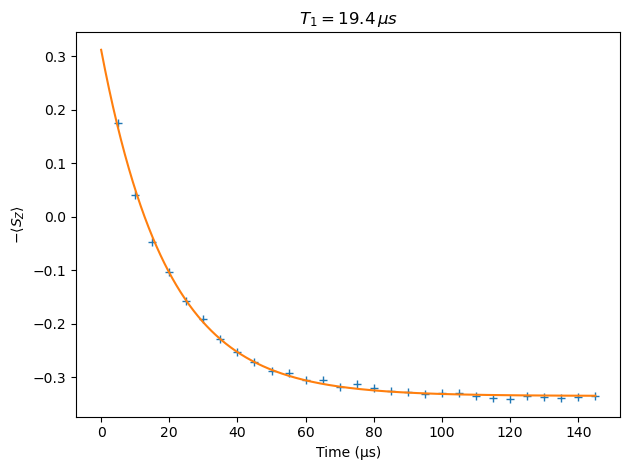

In [48]:
fig,ax=plt.subplots()
tfine = np.linspace(0,t.max(),1000)
ax.plot(t,-Sz,'+',tfine,fun(tfine,*popt))
plt.xlabel('Time (µs)')
plt.ylabel(r'$-\langle S_Z \rangle$')
ax.set_title(rf'$T_1={popt[1]:.1f} \, \mu s$')
fig.tight_layout()
#fig.savefig('RabiChevrons.png')